In [1]:
# Playing with rotation matricies

import numpy as np
import math

lat = 0
long = 0
twist = 270
lat = math.radians(lat)
long = math.radians(long)
twist = math.radians(twist)

print(twist)
print(math.cos(twist))
print(math.sin(twist))


Rx = np.array([[1,0,0],
               [0,np.cos(twist),-np.sin(twist)],
               [0,np.sin(twist),np.cos(twist)]])
Ry = np.array([[np.cos(lat),0,np.sin(lat)],
               [0,1,0],
               [-np.sin(lat),0,np.cos(lat)]])
Rz = np.array([[np.cos(twist),-np.sin(twist),0],
               [np.sin(twist),np.cos(twist),0],
               [0,0,1]])
Rz2 = np.array([[np.cos(long),-np.sin(long),0],
               [np.sin(long),np.cos(long),0],
               [0,0,1]])

print(Rx)

R = Rx
#R = np.matmul(Rz2,Ry,Rx)
#R = np.matmul(Rz2,Ry,Rz)
R = R.flatten()
R[np.abs(R) < 0.0001] = 0


for i in range(1, len(R) + 1):
    print(R[i-1], end=' ')
    if i % 3 == 0:
        print(0, end=' ')
for i in range(3):
    print(0, end=' ')
print(1)

4.71238898038469
-1.8369701987210297e-16
-1.0
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.8369702e-16  1.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00 -1.8369702e-16]]
1.0 0.0 0.0 0 0.0 0.0 1.0 0 0.0 -1.0 0.0 0 0 0 0 1


In [8]:
# Patrick script

# Input: Takes in the GML file 
# Output: A Dictionary indexed by Building Identification with attributes
#         X (min, max), Y (min, max), Z (min, max), BIN, DOITT_ID, SOURCE_ID
def parse(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id]["X"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Y"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Z"] = [float("inf"),-float("inf")]
            current = bldg_id
        if "/bldg:Building" in line:
            current = None
        if "BIN" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['BIN'] = bld_id
        if "DOITT_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['DOITT_ID'] = bld_id
        if "SOURCE_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['SOURCE_ID'] = bld_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                if x > buildings[bldg_id]["X"][1]:
                    buildings[bldg_id]["X"][1] = x
                if x < buildings[bldg_id]["X"][0]:
                    buildings[bldg_id]["X"][0] = x
                if y > buildings[bldg_id]["Y"][1]:
                    buildings[bldg_id]["Y"][1] = y
                if y < buildings[bldg_id]["Y"][0]:
                    buildings[bldg_id]["Y"][0] = y
                if z > buildings[bldg_id]["Z"][1]:
                    buildings[bldg_id]["Z"][1] = z
                if z < buildings[bldg_id]["Z"][0]:
                    buildings[bldg_id]["Z"][0] = z
    return buildings

In [24]:
# Adjusted Patrick script

# Input: Takes in the GML file 
# Output: A dictionary with key = Building Identification (e.g. Bldg_12210009096) 
#         and value = [(X1, Y1, Z1), (X2, Y2, Z2), etc.]
def parseAllCoordinates(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id] = []
            current = bldg_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                buildings[current].append((x,y,z))
        if "/bldg:Building" in line:
            current = None
                
    return buildings

In [22]:
GML_file = '/Users/mogryzko/Desktop/NYC buildings 3D/DA_WISE_GMLs/test/DA12_3D_Buildings_Merged.gml'

building_pts = parseAllCoordinates(GML_file)

In [54]:
u = (3,4,5)

n = np.array(u)

y = np.append(n,np.array([2]), axis=0)
y = y[:3]/y[3]
print(y)
y = y + 3
print(y)


[1.5 2.  2.5]
[4.5 5.  5.5]


In [29]:
print(building_pts['Bldg_12210009096'])


[(988042.890040159, 212057.351853728, 39.1315999999933), (988086.798744991, 212136.782797232, 39.1315999999933), (988105.85480924, 212126.249025643, 39.1315999999933), (988336.49608025, 211998.752889559, 39.1315999999933), (988455.528650582, 211932.952824309, 39.1315999999933), (988431.585128918, 211889.638606474, 39.1315999999933), (988417.384697989, 211863.949681476, 39.1315999999933), (988400.767933324, 211833.889702231, 39.1315999999933), (988397.997597665, 211828.87822932, 39.1315999999933), (988363.03999041, 211765.639838725, 39.1315999999933), (987994.310084835, 211969.469811648, 39.1315999999933), (987999.315652251, 211978.524911642, 39.1315999999933), (987940.271807075, 212011.163297817, 39.1315999999933), (987975.547327086, 212074.977474645, 39.1315999999933), (988030.295249075, 212044.713427559, 39.1315999999933), (988033.86742042, 212051.175028816, 39.1315999999933), (988038.1630155, 212048.800361648, 39.1315999999933), (988042.890040159, 212057.351853728, 39.1315999999933)

In [63]:
new_img.any()

False

In [134]:
len(new_pts)

3489

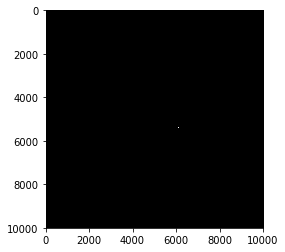

In [ ]:
# TESTING 

import matplotlib.pyplot as plt

pixel_size = 0.00122 # in mm
focal_length = 25 # in mm
fx = focal_length/pixel_size
fy = focal_length/pixel_size
pixels_y, pixels_x = 5000,5000

intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])

R = np.array([[0.822486, -0.568586, 0.0150485],
              [0.0330608, 0.0742028, 0.996695],
              [-0.567824, -0.81927, 0.0798287]])
T = np.array([[-986570],[-209681],[-311.523]])

extrinsic_matrix = np.append(R,T,axis=1)

camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)


new_img = np.zeros((pixels_y, pixels_x))

new_pts = np.zeros((len(building_pts['Bldg_12210009096']),2))

idx = 0
for pt in building_pts['Bldg_12210009096']:
    new_pt = np.append(np.array(pt),np.array([1]), axis=0)
    new_pt = np.matmul(camera_matrix,new_pt)
    new_pt = new_pt[:2]/new_pt[2]
    new_pts[idx] = new_pt
    idx += 1
    
max_x = np.max(new_pts[:,0])
min_x = np.min(new_pts[:,0])
max_y = np.max(new_pts[:,1])
min_y = np.min(new_pts[:,1])



# adjust pts to fit within window
if min_x < 0:
    new_pts -= min_x
if min_y < 0:
    new_pts -= min_y
    
for pt in new_pts:
    if 0 < pt[0]-8000 < pixels_x and 0 < pt[1]-4000 < pixels_y:
        new_img[int((pt[0]-8000)*10),int((pt[1]-4000)*10)] = 1
        
plt.imshow(new_img[1500:2500,4000:5000],cmap='gray')
plt.show()

plt.imsave('new_img.png', new_img, cmap='gray')
        

'''
rx = 0
ry = 0
rz = 0

tx = 0
ty = 0
tz = 0


rx = math.radians(rx)
ry = math.radians(ry)
rz = math.radians(rz)

Rx = np.array([[1,0,0],
               [0,np.cos(twist),-np.sin(twist)],
               [0,np.sin(twist),np.cos(twist)]])
Ry = np.array([[np.cos(lat),0,np.sin(lat)],
               [0,1,0],
               [-np.sin(lat),0,np.cos(lat)]])
Rz = np.array([[np.cos(twist),-np.sin(twist),0],
               [np.sin(twist),np.cos(twist),0],
               [0,0,1]])
Rz2 = np.array([[np.cos(long),-np.sin(long),0],
               [np.sin(long),np.cos(long),0],
               [0,0,1]])


R = np.matmul(Rz2,Ry,Rz)
R[np.abs(R) < 0.0001] = 0
'''



In [ ]:
from scipy.spatial import ConvexHull

points = new_pts

hull = ConvexHull(new_pts)
plt.plot(points[:,1],points[:,0],'o')

plt.show()

In [131]:
asdf=2

In [132]:
xs = {}
for pt in points:
    y = pt[0]*asdf
    x = pt[1]*asdf
    if round(x) not in xs:
        xs[round(x)] = []
    xs[round(x)].append(y)

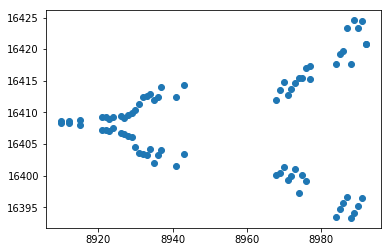

In [133]:
edge_pts = []
for k in xs:
    edge_pts.append((k,min(xs[k])))
    edge_pts.append((k,max(xs[k])))
edge_pts = np.array(edge_pts)

plt.plot(edge_pts[:,0],edge_pts[:,1],'o')
plt.show()

In [ ]:
import cv2

img = cv2.imread('dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('houghlines3.jpg',img)